In [1]:
!sudo apt-get install libtinfo5
!pip install torchtext
!pip install portalocker
!pip install torchdata

'sudo'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ------------------ --------------------- 0.9/1.9 MB 28.5 MB/s eta 0:00:01
   ----------------------------------- ---- 1.7/1.9 MB 36.6 MB/s eta 0:00:01
   ----------------------------------- ---- 1.7/1.9 MB 36.6 MB/s eta 0:00:01
   ------------------------------------ --- 1.8/1.9 MB 14.2 MB/s eta 0:00:01
   ---------------------------------------  1.9/1.9 MB 12.3 MB/s eta 0:00:01
   ---------------------------------------- 1.9/1.9 MB 11.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------  1.3/1.3 MB 42.3 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 21.3 MB/s eta 0:00:00


### 간단한 RNN layer 구현하기

#### 학습용 시계열 데이터 만들기
* 노이즈가 있는 사인 곡선을 시계열 데이터로 사용해서 모델을 학습시킵니다. 그러기 위해서 난수를 더한 sin 함수를 만들어 줍니다.

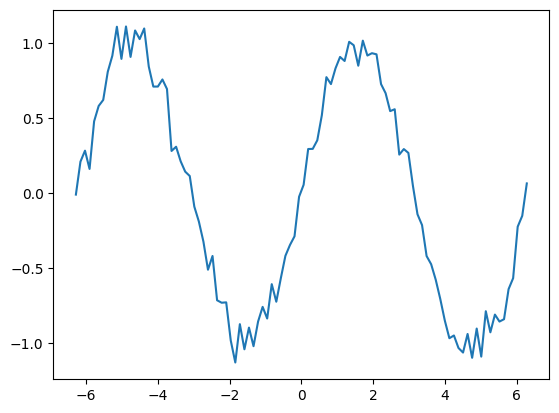

In [2]:
import torch
import math
import matplotlib.pyplot as plt

sin_x = torch.linspace(-2*math.pi, 2*math.pi, 100) # -2pi 부터 2pi까지의 x값
sin_y = torch.sin(sin_x) + 0.1*torch.randn(len(sin_x)) # sin함수 값에 난수를 더해서 저장
plt.plot(sin_x, sin_y)
plt.show()

* 출력된 그래프의 가로축은 시간에 해당하고 세로축은 해당 시간의 값을 나타내는 시계열 데이터의 그래프

#### 데이터 전처리
* 사인 곡선의 시계열 데이터를 RNN의 입력값과 레이블값에 적합한 형태로 전처리
* 입력데이터의 형태는 (샘플 개수, 시각 개수, 각 시각의 입력 개수)이다.
* 레이블 데이터의 형태는 (샘플 개수, 정답 개수)인데, 정답 개수는 1

In [3]:
from torch.utils.data import TensorDataset, DataLoader

n_time = 10      # 시각 개수, 얼마만큼의 시계열 값을 담을 지 정하는 하이퍼파라미터
n_sample = len(sin_x) - n_time    # 샘플의 개수

input_data = torch.zeros((n_sample, n_time, 1)) # 입력값
correct_data = torch.zeros((n_sample, 1)) # 레이블 값

for i in range(n_sample):
   input_data[i] = sin_y[i:i+n_time].view(-1,1)    # 입력 시계열 데이터
   correct_data[i] = sin_y[i+n_time:i+n_time+1]    # 레이블 시계열 데이터( 입력보다 1t 이후)

dataset = TensorDataset(input_data, correct_data) # 데이터셋
train_loader = DataLoader(dataset, batch_size = 8, shuffle=True)

#### 모델 구축
* nn.Module()클래스를 상속받은 클래스로 RNN을 구축
* 최종 시각의 출력만 이용하기 때문에, forward() 메서드는 마지막 출력만 반환

In [4]:
import torch.nn as nn

class Net(nn.Module):
   def __init__(self):
      super().__init__()
      self.rnn = nn.RNN(
         input_size = 1,
         hidden_size = 64,
         batch_first = True)
      self.fc = nn.Linear(64,1)

   def forward(self, x):
      y_rnn, h = self.rnn(x, None)
      y = self.fc(y_rnn[:, -1, :])
      return y

net = Net()
print(net)

Net(
  (rnn): RNN(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


#### 학습
* DataLoader를 사용해 RNN모델을 미니 배치 학습을 실시

Epoch: 0 Loss_train: 0.44923353955770534
Epoch: 10 Loss_train: 0.04266203986480832
Epoch: 20 Loss_train: 0.030215094176431496
Epoch: 30 Loss_train: 0.02405410531597833
Epoch: 40 Loss_train: 0.013934927837302288
Epoch: 50 Loss_train: 0.011480946394537265
Epoch: 60 Loss_train: 0.011340813769493252
Epoch: 70 Loss_train: 0.011199589590736045
Epoch: 80 Loss_train: 0.011321803399672111
Epoch: 90 Loss_train: 0.011236827510098616


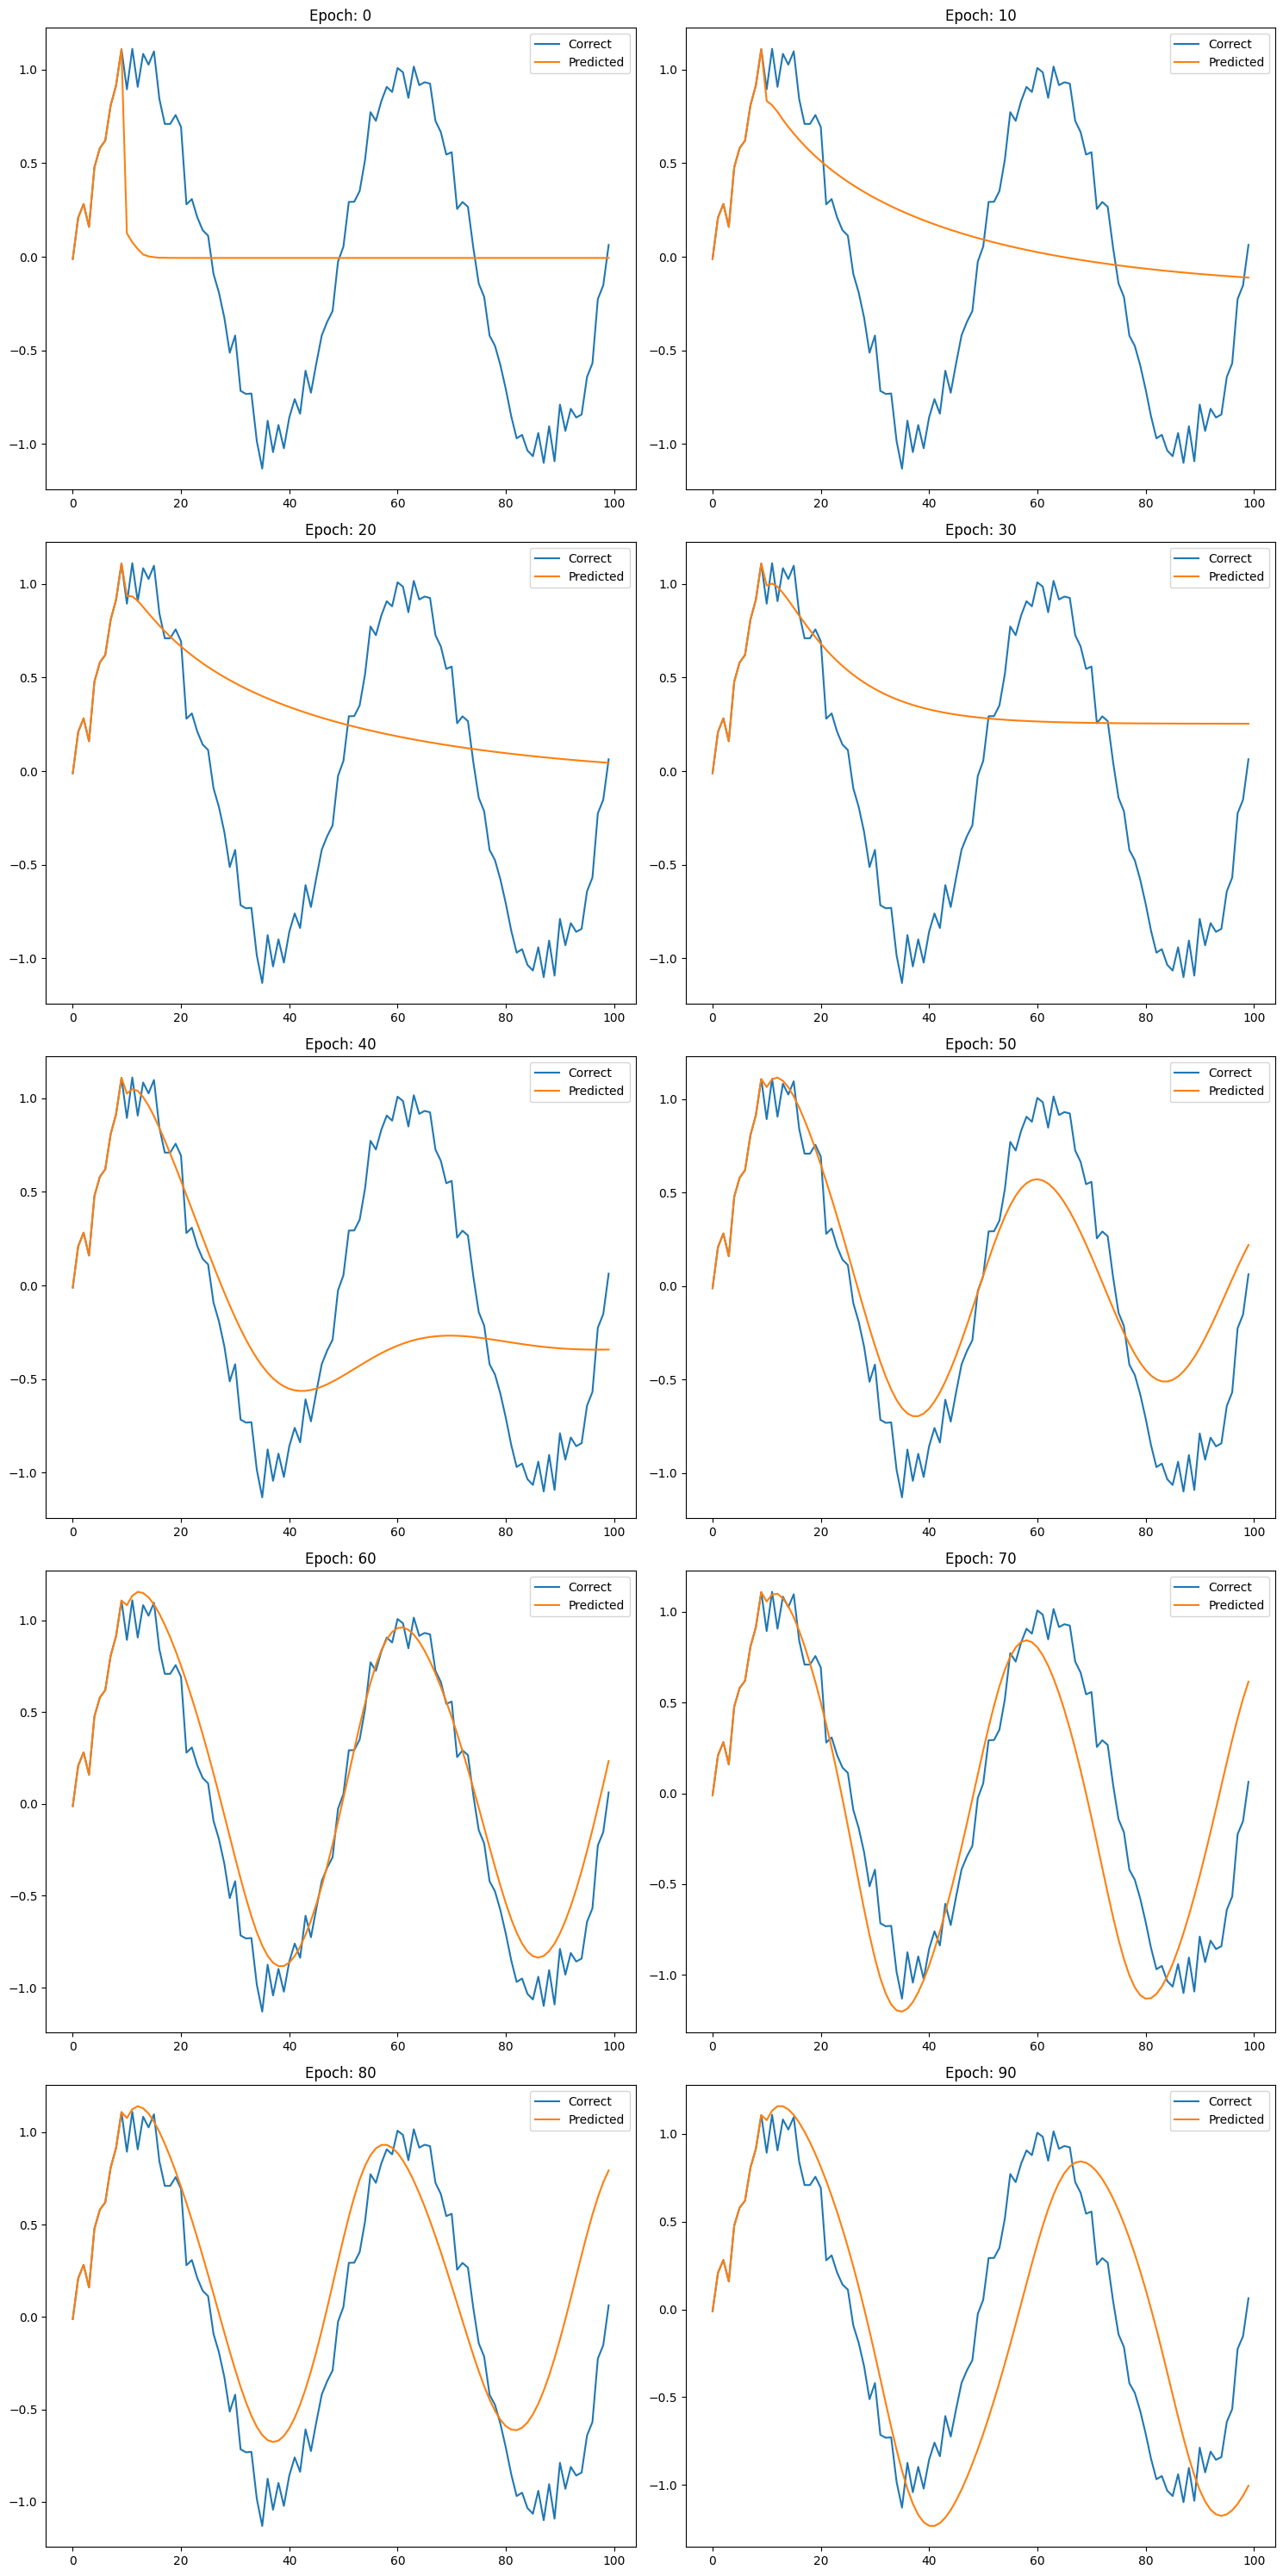

In [5]:
from torch import optim

loss_fnc = nn.MSELoss() # 평균 제곱 오차를 사용
optimizer = optim.SGD(net.parameters(), lr=0.01) # SGD 옵티마이저를 사용하고 학습률은 0.01이다.

record_loss_train = []  # 손실함수의 값을 기록
epochs = 100  # 100 에포크 학습

# 행 5개, 열 2개로 서브 플롯 만들기
fig, axs = plt.subplots(5, 2, figsize=(15, 30))
axs = axs.flatten()

# 서브플롯 인덱스 카운터
plot_idx = 0

for i in range(epochs):
   net.train() # 모델을 학습모드로 지정
   loss_train = 0 # 초기 손실 값을 0으로 정의
   for j, (x, t) in enumerate(train_loader):  # 미니 배치 (x, t)를 꺼낸다.
      y = net(x)  # 신경망을 통과한 x의 값이 y값이 된다.
      loss = loss_fnc(y, t)  # 출력된 y와 레이블인 t의 차이를 구한다.
      loss_train += loss.item() # 손실값을 반복문을 순회하면서 더해준다.
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
   loss_train /= (j + 1)
   record_loss_train.append(loss_train)

   if i % 10 == 0 and i <= 100:
      net.eval() # 모델을 평가모드로 지정
      print("Epoch:", i, "Loss_train:", loss_train)
      predicted = list(input_data[0].view(-1))
      for _ in range(n_sample):
         x = torch.tensor(predicted[-n_time:])  # 최근 시계열 데이터를 꺼낸다.
         x = x.view(1, n_time, 1)   # (배치 크기, 시각 개수, 입력 개수)
         y = net(x)
         predicted.append(y[0].item())    # 예측 결과를 predicted에 추가


      axs[plot_idx].plot(range(len(sin_y)), sin_y, label="Correct")
      axs[plot_idx].plot(range(len(predicted)), predicted, label="Predicted")
      axs[plot_idx].set_title(f'Epoch: {i}')
      axs[plot_idx].legend()
      plot_idx += 1

plt.tight_layout()
plt.show()

#### 오차의 추이

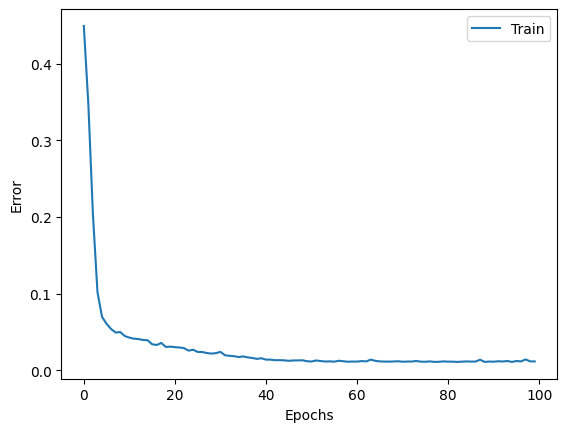

In [6]:
plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

### LSTM 구현하기

#### 데이터 전처리

In [7]:
import numpy as np

# 학습용 문장 정의
sentences = ["i like dog", "i love coffee", "i hate milk", "you like cat", "you love milk", "you hate coffee"]
dtype = torch.float

"""
단어 전처리
"""
# 문장의 고유 단어 목록 만들기
word_list = list(set(" ".join(sentences).split()))
# 각 단어를 고유 인덱스에 매핑하는 사전 만들기
word_dict = {w: i for i, w in enumerate(word_list)}
# 각 인덱스를 해당 단어에 다시 매핑하는 사전을 만듭니다.
number_dict = {i: w for i, w in enumerate(word_list)}
# 말뭉치의 고유 단어 개수
n_class = len(word_dict)

#### 모델 파라미터 정의
* TextLSTM 모델의 파라미터를 정의하고 배치 학습을 위한 데이터를 준비

In [8]:
"""
TextLSTM 파라미터
"""
# 배치 학습을 위한 배치 사이즈
batch_size = len(sentences)
# 각 시각 단계마다 LSTM에 공급되는 단어 개수
n_step = 2
# LSTM의 은닉 레이어의 뉴런 개수
n_hidden = 5

# sentenses을 원핫 인코딩된 입력과 정수 타겟으로 변환시키는 함수
def make_batch(sentences):
    input_batch = []
    target_batch = []

    for sen in sentences:
        word = sen.split()
        input = [word_dict[n] for n in word[:-1]]
        target = word_dict[word[-1]]
        input_batch.append(np.eye(n_class)[input])  # 원핫 인코딩
        target_batch.append(target)
    
    return input_batch, target_batch

# 데이터 준비
input_batch, target_batch = make_batch(sentences)
input_batch = torch.tensor(input_batch, dtype=torch.float32, requires_grad=True)
target_batch = torch.tensor(target_batch, dtype=torch.int64)

C:\Users\008yo\AppData\Local\Temp\ipykernel_5336\1852500835.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  input_batch = torch.tensor(input_batch, dtype=torch.float32, requires_grad=True)


#### 모델 정의 및 학습
* nn.Module 클래스를 상속받은 TextLSTM클래스에 모델을 정의하고 학습

In [9]:
"""
TextLSTM
"""
class TextLSTM(nn.Module):
    def __init__(self):
        super(TextLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=n_class, hidden_size=n_hidden, dropout=0.3)
        self.W = nn.Parameter(torch.randn([n_hidden, n_class]).type(dtype))
        self.b = nn.Parameter(torch.randn([n_class]).type(dtype))
        self.Softmax = nn.Softmax(dim=1)

    def forward(self, hidden_and_cell, X):
        X = X.transpose(0, 1)
        outputs, hidden = self.lstm(X, hidden_and_cell)
        outputs = outputs[-1] 
        model = torch.mm(outputs, self.W) + self.b 
        return model

"""
학습
"""
model = TextLSTM()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(500):
    hidden = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
    cell = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
    output = model((hidden, cell), input_batch)
    loss = criterion(output, target_batch)

    if (epoch + 1) % 100 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

C:\Users\008yo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0100 cost = 0.625568
Epoch: 0200 cost = 0.036058
Epoch: 0300 cost = 0.012763
Epoch: 0400 cost = 0.007064
Epoch: 0500 cost = 0.004631


#### 모델 테스트 및 결과 출력

In [10]:
# 모델 테스트
hidden = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
cell = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
predict = model((hidden, cell), input_batch).data.max(1, keepdim=True)[1]

# 입력 문장과 이에 해당된 예측 출력
for sentence, pred_idx in zip(sentences, predict.squeeze()):
    print('Sentence:', sentence, '-> Predicted:', number_dict[pred_idx.item()])

Sentence: i like dog -> Predicted: dog
Sentence: i love coffee -> Predicted: coffee
Sentence: i hate milk -> Predicted: milk
Sentence: you like cat -> Predicted: cat
Sentence: you love milk -> Predicted: milk
Sentence: you hate coffee -> Predicted: coffee


* RNN 및 LSTM은 시계열 데이터 및 순서가 있는 데이터를 활용하여 미래를 예측하는 인공지능 모델